# Homework 3 - Ames Housing Dataset

##Uploading Data


For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [0]:
## Mouting zip file from google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## Unzipping the file

from zipfile import ZipFile
filename = '/content/drive/My Drive/house-prices-advanced-regression-techniques.zip'

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("Done")

Done


In [0]:
import pandas as pd
import numpy as np


train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


## `Data Cleaning`

**Removing insignificant columns**

1) Removing insignificant values from the dataframe. I have followed the following criteria:

2) Removed columns which were having only 1 unique data. This was removed as these columns will not have any impact on the predictions for fraudulent transactions.

3) Removed columns which are having 90% have their data as NaN.

4) Columns which are highly dominated by large data, i.e., even after normalization.

In [0]:
# remove insignificant features

one_value_cols_train = [col for col in train_data.columns if train_data[col].nunique() <= 1]  ## []
one_value_cols_test = [col for col in test_data.columns if test_data[col].nunique() <= 1]  ##['V107']

train_data_rows = train_data.shape[0]
test_data_rows = test_data.shape[0]

many_null_cols_train = [col for col in train_data.columns if train_data[col].isnull().sum() / train_data_rows > 0.9]
many_null_cols_test = [col for col in test_data.columns if test_data[col].isnull().sum() / test_data_rows > 0.9]

# big_top_value_cols_train = [col for col in train_data.columns if train_data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
# big_top_value_cols_test = [col for col in test_data.columns if test_data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(one_value_cols_train + one_value_cols_test + many_null_cols_train + many_null_cols_test))

# cols_to_drop.remove('SalePrice')

print('{} features are going to be dropped'.format(len(cols_to_drop)))

print(cols_to_drop)

4 features are going to be dropped
['MiscFeature', 'Alley', 'PoolQC', 'Utilities']


In [0]:
## Testing for missing drop columns
for col in cols_to_drop:
    if col not in train_data.columns:
        print("missing drop column in train",col)
    if col not in test_data.columns:
        print("Missing drop columns in test",col)

In [0]:
## Dropping useless Columns

train_data = train_data.drop(cols_to_drop, axis=1)
test_data = test_data.drop(cols_to_drop, axis=1)
print(train_data.shape)
print(test_data.shape)
train_df = train_data

(1460, 77)
(1459, 76)


In [0]:
train_data.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 77 columns]

**Sanity check**


Before we go on and process this data, we need to be sure it actually makes sense. There are three "low hanging fruits" in this sense:

  1) Features that represent years should not go take values larger than 2010.
  
  2) Areas, distances and prices should not take negative values.
  
  3) Months should be between 1 and 12

In [0]:
years = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
metrics = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
         'OpenPorchSF', 'EnclosedPorch']
train_data[years].max() 

YearBuilt       2010.0
YearRemodAdd    2010.0
GarageYrBlt     2010.0
YrSold          2010.0
dtype: float64

In [0]:
test_data[years].max()

YearBuilt       2010.0
YearRemodAdd    2010.0
GarageYrBlt     2207.0
YrSold          2010.0
dtype: float64

Found that GaragaeYrBlt is having wrong built year '**2207**' in few rows.

In [0]:
mask = (train_data[metrics] < 0).any(axis=1)
train_data[mask]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

In [0]:
mask = ((train_data['MoSold'] > 12) | (train_data['MoSold'] < 1))
train_data[mask]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

## Part 1 - Pairwise Correlations

**Finding top 10 positively correlated features with SalePrice**

In [0]:
print("10 most positively correlated features")
n = 20
corr_matrix = train_data.corr()
corr_matrix.nlargest(n,'SalePrice')['SalePrice']

10 most positively correlated features


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
Name: SalePrice, dtype: float64

**Find top 10 most negatively correlated features w.r.t SalePrice**

In [0]:
print("10 most negatively correlated features")
n=10
corr_matrix.nsmallest(n,'SalePrice')['SalePrice']

10 most negatively correlated features


KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

**Correlation table for Hand-picked features after finding most negatively and positively correlated features**

In [0]:
train_data[['SalePrice','OverallQual','GrLivArea', "GarageCars","GarageArea","TotalBsmtSF","KitchenAbvGr", "EnclosedPorch","MSSubClass", \
           "OverallCond", "YrSold","LowQualFinSF"]].corr()

SalePrice  OverallQual  ...    YrSold  LowQualFinSF
SalePrice       1.000000     0.790982  ... -0.028923     -0.025606
OverallQual     0.790982     1.000000  ... -0.027347     -0.030429
GrLivArea       0.708624     0.593007  ... -0.036526      0.134683
GarageCars      0.640409     0.600671  ... -0.039117     -0.094480
GarageArea      0.623431     0.562022  ... -0.027378     -0.067601
TotalBsmtSF     0.613581     0.537808  ... -0.014969     -0.033245
KitchenAbvGr   -0.135907    -0.183882  ...  0.031687      0.007522
EnclosedPorch  -0.128578    -0.113937  ... -0.009916      0.061081
MSSubClass     -0.084284     0.032628  ... -0.021407      0.046474
OverallCond    -0.077856    -0.091932  ...  0.043950      0.025494
YrSold         -0.028923    -0.027347  ...  1.000000     -0.028921
LowQualFinSF   -0.025606    -0.030429  ... -0.028921      1.000000

[12 rows x 12 columns]

**HeatMap for top 11 correlated Features w.r.t SalePrice**

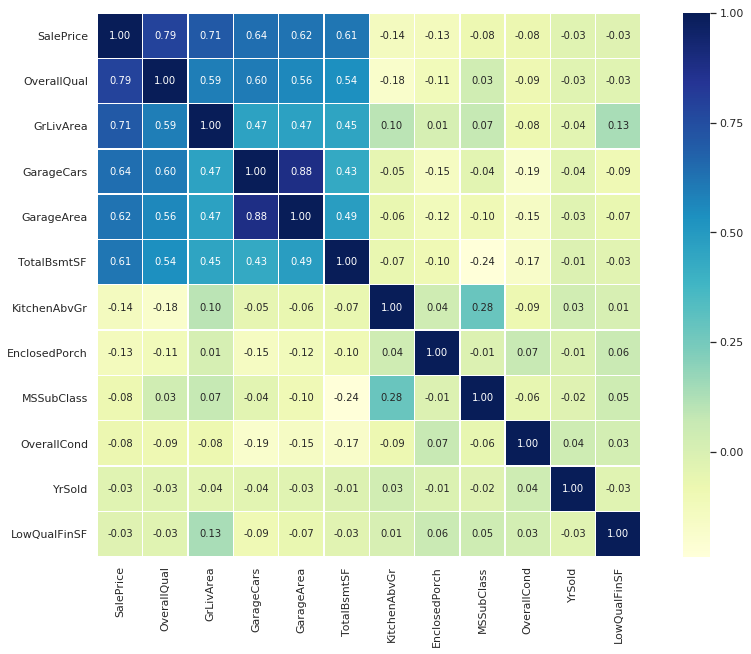

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15, 10))
k=11
cols = train_data[['SalePrice','OverallQual','GrLivArea', "GarageCars","GarageArea","TotalBsmtSF","KitchenAbvGr", "EnclosedPorch","MSSubClass", \
           "OverallCond", "YrSold","LowQualFinSF"]].corr().index
cm = np.corrcoef(train_data[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},linewidths=.5,cmap="YlGnBu",yticklabels=cols.values,
                 xticklabels=cols.values, ax =ax)
plt.show()

As seen from the heatmap, we can see that strong positive correlations exists between SalePrice and features like OverallQual(Overall material and finish quality) and GrLivArea(Above grade (ground) living area square feet). This makes sense as better quality of the material used for making houses will make a house more expensive. It is also intuitive that price of the house is proportional to the living area.


Features like EnclosedPorch(Enclosed porch area in square feet) and KitchenAbvGr is most negatively correlated with SalePrice. This means that on increase of porch area and if there is Kitchen above Garage, sale price may decrease.

Another, strong correlation exists between GarageCars(Size of garage in car capacity) and GarageArea(Size of garage in square feet). This makes sense as bigger garage will have more car capacity.



## Part 2 - Informative Plots

**MoSold vs SalePrice Sum in a Month**

In [0]:
SalePrice_sum = train_data.groupby('MoSold').sum()[['SalePrice']]
months = [1,2,3,4,5,6,7,8,9,10,11,12]

SalePrice_sum["Months"] = months
SalePrice_sum

SalePrice  Months
MoSold                   
1        10628863       1
2         9249864       2
3        19424916       3
4        24181960       4
5        35150683       5
6        44881121       6
7        43601499       7
8        22527523       8
9        12328042       9
10       15981194      10
11       15184662      11
12       11004619      12

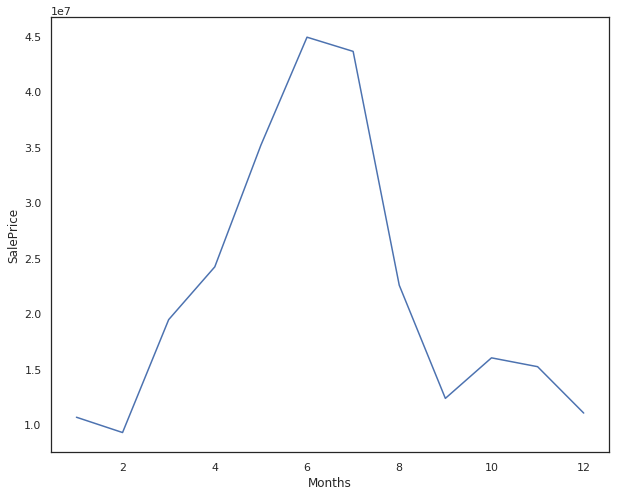

In [0]:
plt.figure(figsize=(10,8));
sns.lineplot(x="Months", y="SalePrice",
                 data=SalePrice_sum)

Most sales in summer months as sum of SalePrice is maximum between months 5 and 7, i.e, May and July. The least sum are found at the end or start of the Year.

**SalePrice vs OverallCond**

In [0]:
qual_pivot = train_data.pivot_table(index='OverallQual', 
                               values='SalePrice', 
                               aggfunc=np.mean)
display(qual_pivot)

SalePrice
OverallQual               
1             50150.000000
2             51770.333333
3             87473.750000
4            108420.655172
5            133523.347607
6            161603.034759
7            207716.423197
8            274735.535714
9            367513.023256
10           438588.388889

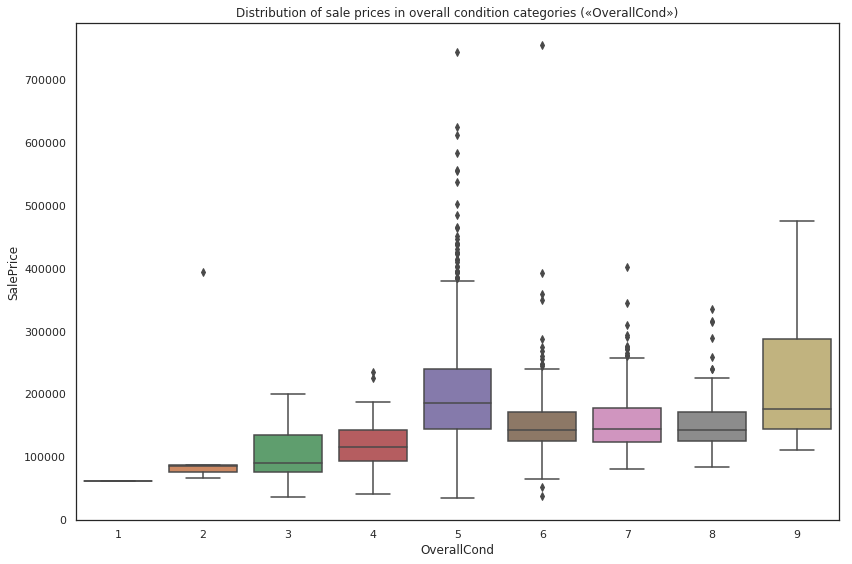

In [0]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="OverallCond", y="SalePrice", data=train_df)
plt.title("Distribution of sale prices in overall condition categories («OverallCond»)")
plt.ylabel("SalePrice")
plt.tight_layout()
plt.show()

Only very few properties are rated below average (5).
Average (5) is the category value of overall condition that has by far the most counts.

The mean sale price for «Average» is higher than for «Above Average» and higher.


One possible explanation could be that as long as the house is in average condition it can be fixed to a higher condition without that much additional cost. If the base materials and finish are not good, than a prospective owner would have much more difficulties upping the property.

**Season vs SalePrice**

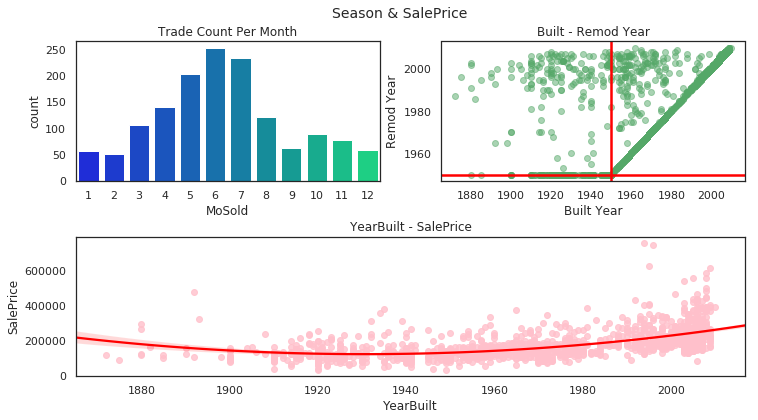

In [0]:
season = ['YearBuilt', 'YearRemodAdd','GarageYrBlt', 'MoSold', 'YrSold', 'SalePrice']
plt.figure(figsize = (12,6))
ax1 = plt.subplot2grid((2,2), (0,0))
sns.countplot(x = 'MoSold', palette = sns.color_palette('winter', 12), data =train_df, ax = ax1)
ax1.set_title('Trade Count Per Month')

ax2 = plt.subplot2grid((2,2), (0,1))
ax2.scatter(x = train_df['YearBuilt'], y = train_df['YearRemodAdd'], alpha = 0.5, color = 'g')
ax2.axvline(1950, color = 'red', linewidth = 2.5)
ax2.axhline(1950, color = 'red', linewidth = 2.5)
ax2.set_xlabel('Built Year')
ax2.set_ylabel('Remod Year')
ax2.set_title('Built - Remod Year')

ax3 = plt.subplot2grid((2,2), (1,0), colspan = 2)
sns.regplot(x = 'YearBuilt', y = 'SalePrice', color = 'pink', order = 2, line_kws = {'color' : 'red'}, ax = ax3, data =train_df)
ax3.set_title('YearBuilt - SalePrice')
plt.subplots_adjust(top = 0.9, hspace = 0.4)
plt.suptitle('Season & SalePrice', fontsize = 14)
#sns.despine()
plt.show()

1) The amount of trade was increased by rising temperature


2) Most of old built house remodeled at 1950.

3) The part of house, built after 1950, was not remodeled yet.

4) YearBuilt^2 is proper if the variables is used to predict

**SalePrice vs GrLivArea**

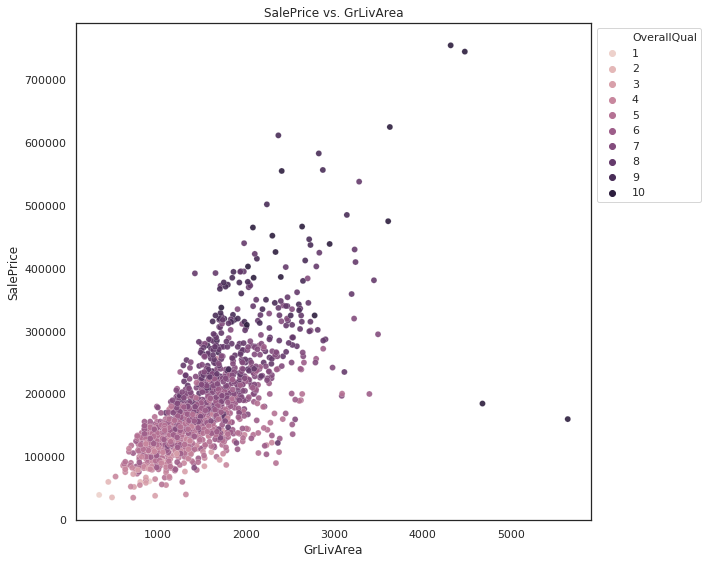

In [0]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="GrLivArea", y="SalePrice", hue="OverallQual", data=train_df, 
                legend="full", linewidth=0.2, alpha=0.9)
plt.title(f"SalePrice vs. GrLivArea")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.tight_layout()
plt.show()

Low overall quality data points plot with light hue in lower ranges of living area and sale price. The OverallQual is spread across as it can be found with less living Area as well as more living Area along. There are certain outliers which indicates that some Houses are really expensive and those may represent a mansion as the GrLivArea and SalePrice is high for those.

**Count of Sales observations in years of Sale**

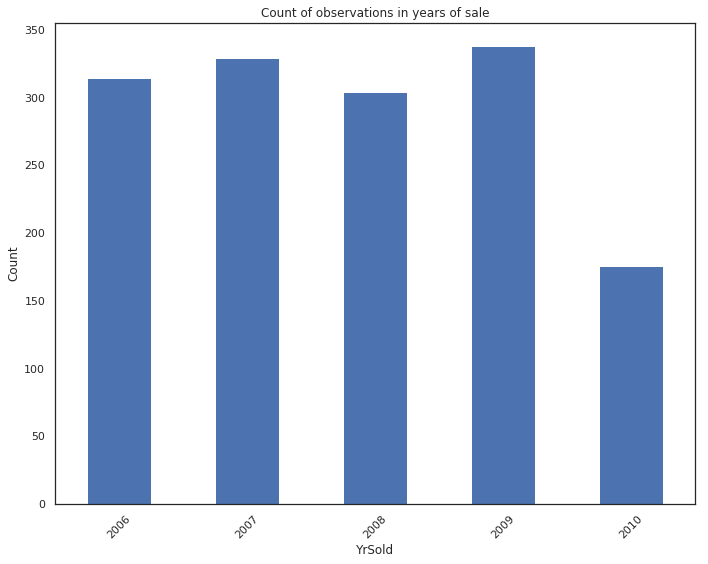

In [0]:
plt.figure(figsize=(10,8));
train_df.groupby("YrSold").SalePrice.count().plot(kind="bar")
plt.title("Count of observations in years of sale")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Maximum sales of Houses occured in 2007 and 2009. Fewer sales in 2010. Could be either because less samples were collected. Or the financial crisis of 2009 hit the market.

## Part 3 - Handcrafted Scoring Function

**Scoring Function**


Assumptions: Best OverallQuality , large Living Area and Garage Area, and Newly Built Houses(from YearBuilt) are most desirable.

In [0]:
dict={}
def find_scores(train_df):
  for index, row in train_df.iterrows():
    score = 0.25*row["OverallQual"] +  0.20*row["GrLivArea"] + 0.10*row["GarageArea"] + 0.08*row["TotalBsmtSF"]
    + 0.07*row["1stFlrSF"] + 0.06*row["FullBath"] + 0.05*row["TotRmsAbvGrd"] + 0.05*(1/(2010 - row["YearBuilt"]))
    + 0.05*(1/(2010 - row["YearRemodAdd"])) + 0.05* row["MasVnrArea"] + 0.05 * row["Fireplaces"] + 0.05 * row["OpenPorchSF"]

    dict[row["Id"]] = (score, row["SalePrice"], row["Neighborhood"])
  return dict

cols = ["OverallQual", "GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "FullBath", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd", "MasVnrArea", 
        "Fireplaces","OpenPorchSF"] 

df = train_data[cols] 

for i in df.columns:
    df[i].fillna(df[i].median(),inplace=True)

df_norm = (df - df.mean()) / (df.max() - df.min())
df_norm["Id"] = train_data[["Id"]]
df_norm["SalePrice"] = train_data[["SalePrice"]]
df_norm["Neighborhood"] = train_data[["Neighborhood"]]

temp = find_scores(df_norm)
len(temp)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


1460

**Top 10 Most Desirable Houses** 

In [0]:
top_10_desirable = sorted(temp.items(), key=lambda x: x[1][0], reverse = True)[:10]
top_10_desirable

[(1299, (0.39663534790326777, 160000, 'Edwards')),
 (524, (0.28366552678106643, 184750, 'Edwards')),
 (1183, (0.26140745861924997, 745000, 'NoRidge')),
 (692, (0.2573472158769892, 755000, 'NoRidge')),
 (1170, (0.22289340456653392, 625000, 'NoRidge')),
 (186, (0.21372894806359896, 475000, 'OldTown')),
 (826, (0.19581808172598905, 385000, 'NridgHt')),
 (1374, (0.19443352035150846, 466500, 'NoRidge')),
 (225, (0.19376298986112175, 386250, 'NridgHt')),
 (584, (0.18686536390940645, 325000, 'OldTown'))]

In [0]:
top_10_desirable_house_ids = [1299, 524, 1183, 692, 1170, 186, 826, 1374, 225, 584]

train_data.loc[train_data['Id'].isin(top_10_desirable_house_ids)][
    ["Id","OverallQual", "GrLivArea", "GarageArea", "TotalBsmtSF", "Neighborhood","1stFlrSF", 
        "FullBath", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd", "MasVnrArea", 
        "Fireplaces","OpenPorchSF","SalePrice"]]

Id  OverallQual  GrLivArea  ...  Fireplaces  OpenPorchSF SalePrice
185    186           10       3608  ...           2          260    475000
224    225           10       2392  ...           1          105    386250
523    524           10       4676  ...           1          406    184750
583    584           10       2775  ...           1          502    325000
691    692           10       4316  ...           2           50    755000
825    826           10       2084  ...           1           45    385000
1169  1170           10       3627  ...           1           76    625000
1182  1183           10       4476  ...           2           78    745000
1298  1299           10       5642  ...           3          292    160000
1373  1374           10       2633  ...           2          140    466500

[10 rows x 15 columns]

The Scoring fuction performed well for most desirable houses. As for top 10 desirable houses, we can see that all HouseIds have best OverAll Quality and HouseIds **1299**, **524** and **1183** can be distinguished based on Living Area, Garage Area and Year Built. I have assumed that new built houses are more desirable along with the Living Area and Garage Area. Several other factors like TotalBsmtSF, Remodified year and Fire Places. Also, I am able to find the most valued house, i.e., **1299** having all the amenities at least SalePrice 160000. Apart from that, one could see most desirable houses are found in NoRidge as 4 houses 692, 1170, 1183 and 1374 are in top 10.





**10 Least Desirable Houses**

In [0]:
least_10_desirable = sorted(temp.items(), key=lambda x: x[1][0])[:10]
least_10_desirable

[(534, (-0.23336465209673224, 39300, 'BrkSide')),
 (376, (-0.2029449194139522, 61000, 'Edwards')),
 (637, (-0.18457184342959498, 60000, 'BrkSide')),
 (1101, (-0.18052282889824023, 60000, 'SWISU')),
 (917, (-0.1720802314716015, 35311, 'IDOTRR')),
 (711, (-0.15939071314804623, 52000, 'BrkSide')),
 (1327, (-0.15410759789231634, 79000, 'Edwards')),
 (621, (-0.14652663742995647, 67000, 'Edwards')),
 (969, (-0.1460646524941464, 37900, 'OldTown')),
 (1322, (-0.14302523781023005, 72500, 'BrkSide'))]

In [0]:
least_10_desirable_house_ids = [534, 376, 637, 1101, 917, 711, 1327, 621, 969, 1322]

train_data.loc[train_data['Id'].isin(least_10_desirable_house_ids)][
    ["Id","OverallQual", "GrLivArea", "GarageArea", "TotalBsmtSF", "Neighborhood","1stFlrSF", 
        "FullBath", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd", "MasVnrArea", 
        "Fireplaces","OpenPorchSF","SalePrice"]]

Id  OverallQual  GrLivArea  ...  Fireplaces  OpenPorchSF SalePrice
375    376            1        904  ...           0            0     61000
533    534            1        334  ...           0            0     39300
620    621            3        864  ...           0            0     67000
636    637            2        800  ...           1            0     60000
710    711            3        729  ...           0            0     52000
916    917            2        480  ...           0            0     35311
968    969            3        968  ...           0            0     37900
1100  1101            2        438  ...           0            0     60000
1321  1322            3        720  ...           0            0     72500
1326  1327            3        774  ...           0            0     79000

[10 rows x 15 columns]

The score function performed well for least desirable as well. HouseIds 534 have the least quality and Living Area. Also, more numbers of least desirable houses are found in BrkSide. 

## Part 4 - Pairwise Distance Function

In [0]:
X,y = train_data.loc[:, train_data.columns != 'Neighborhood'],train_data.Neighborhood
X.shape

(1460, 76)

**Converting Categorical data to numerical format.**

Used two methods for it:

1. Label Encoding - It performed better for the model. Hence, used this. Assumed NAN as a category type by replacing nan with a string and then performed Label Encoding.

2. Used factorize of pandas earlier but it did not perform well with the model.

In [0]:
from sklearn import preprocessing

temp_train = X

for f in temp_train.columns:
  if f not in cols_to_drop and f!='SalePrice':
    if temp_train[f].dtype=='object': 
      print("label encoding ",f)
      temp_train[f].fillna("NaN", inplace = True)
      lbl = preprocessing.LabelEncoder()
      lbl.fit(list(temp_train[f].values))
      temp_train[f] = lbl.transform(list(temp_train[f].values))

print(temp_train.shape)


label encoding  MSZoning


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


label encoding  Street
label encoding  LotShape
label encoding  LandContour
label encoding  LotConfig
label encoding  LandSlope
label encoding  Condition1
label encoding  Condition2
label encoding  BldgType
label encoding  HouseStyle
label encoding  RoofStyle
label encoding  RoofMatl
label encoding  Exterior1st
label encoding  Exterior2nd
label encoding  MasVnrType
label encoding  ExterQual
label encoding  ExterCond
label encoding  Foundation
label encoding  BsmtQual
label encoding  BsmtCond
label encoding  BsmtExposure
label encoding  BsmtFinType1
label encoding  BsmtFinType2
label encoding  Heating
label encoding  HeatingQC
label encoding  CentralAir
label encoding  Electrical
label encoding  KitchenQual
label encoding  Functional
label encoding  FireplaceQu
label encoding  GarageType
label encoding  GarageFinish
label encoding  GarageQual
label encoding  GarageCond
label encoding  PavedDrive
label encoding  Fence
label encoding  SaleType
label encoding  SaleCondition
(1460, 76)


**IMPUTING NANs**

1. Checked if some column contains some infinite value, then replaced with NaN

2. Imputed NANs with the median of the column as the mean might not be a good way to impute if the columns are affected by outliers.

In [0]:
temp = temp_train
for i in temp.columns:
    temp[i].fillna(temp[i].median(),inplace=True) # filled with median because mean may be affected by outliers.

print(temp.isna().sum().sum())

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0


**Selecting 20 best features**

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression

selector = SelectKBest(chi2, k=20)
selector.fit(temp, y)

X_new = selector.transform(temp)
print(X_new.shape)

X.columns[selector.get_support(indices=True)]


# 1st way to get the list
vector_names = list(temp.columns[selector.get_support(indices=True)])
print(vector_names)
print(type(vector_names))

(1460, 20)
['Id', 'MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']
<class 'list'>


**Calculating the distance between features**

Applied PCA for dimension reduction

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler, RobustScaler

features = vector_names

x = temp.loc[:, features].values
y = train_data.loc[:,['Neighborhood']].values
x = StandardScaler().fit_transform(x)
pd.DataFrame(data = x, columns = features).head()

Id  MSSubClass   LotArea  ...  PoolArea   MiscVal  SalePrice
0 -1.730865    0.073375 -0.207142  ... -0.068692 -0.087688   0.347273
1 -1.728492   -0.872563 -0.091886  ... -0.068692 -0.087688   0.007288
2 -1.726120    0.073375  0.073480  ... -0.068692 -0.087688   0.536154
3 -1.723747    0.309859 -0.096897  ... -0.068692 -0.087688  -0.515281
4 -1.721374    0.073375  0.375148  ... -0.068692 -0.087688   0.869843

[5 rows x 20 columns]

In [0]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf.head(5)

principal component 1  principal component 2
0               0.044760               1.119555
1               0.279777              -1.738140
2               0.312049               1.229293
3              -0.975877               1.513671
4               2.402287               1.640869

Used Euclidean distance function for the two PCA. Euclidean distance is a technique used to find the distance/dissimilarity among objects.
As the data is dense or continuous, this is the best proximity measure for our case.

In [0]:
from sklearn.cluster import AgglomerativeClustering


clustering_5 = AgglomerativeClustering(n_clusters=5,
                                    linkage="ward", affinity="euclidean").fit(principalDf)
finalDf = pd.concat([principalDf, pd.DataFrame(data={'NeighborHood':clustering_5.labels_})], axis = 1)
finalDf.shape

finalDf.columns

Index(['principal component 1', 'principal component 2', 'NeighborHood'], dtype='object')

## Part 5 - Clustering

**Applying Agglomerative Clustering**

**5 clusters**

Below graph shows the homogeneous clusters of neighborhood. As we can see the neighborhood clustered well and one can easily distinguish the neighborhood boundaries with 5 clusters. 24 neighborhoods combined to 5. 

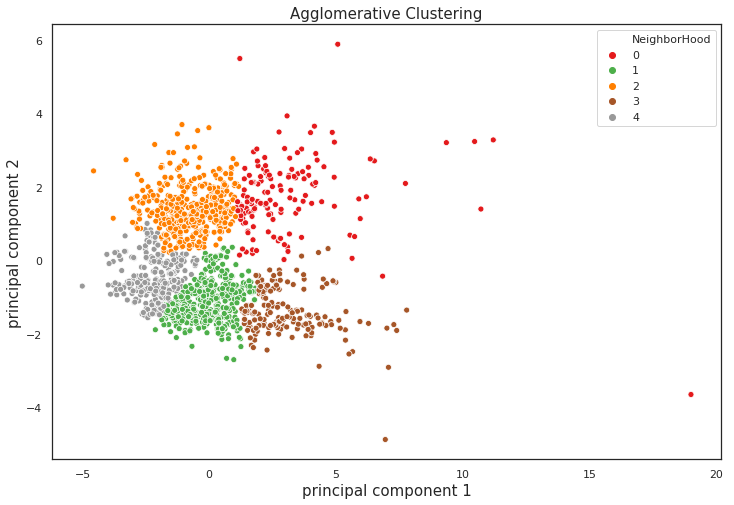

In [0]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Agglomerative Clustering', fontsize = 15)


sns.scatterplot(x='principal component 1',y='principal component 2',hue='NeighborHood',data=finalDf,legend="full",palette='Set1')

**10 clusters**

Neighborhood Boundaries is still distinguishable with 10 clustered neighborhood.

In [0]:
clustering = AgglomerativeClustering(n_clusters=10,
                                    linkage="ward", affinity="euclidean").fit(principalDf)
finalDf = pd.concat([principalDf, pd.DataFrame(data={'NeighborHood':clustering.labels_})], axis = 1)
finalDf.shape

finalDf.columns

Index(['principal component 1', 'principal component 2', 'NeighborHood'], dtype='object')

No handles with labels found to put in legend.


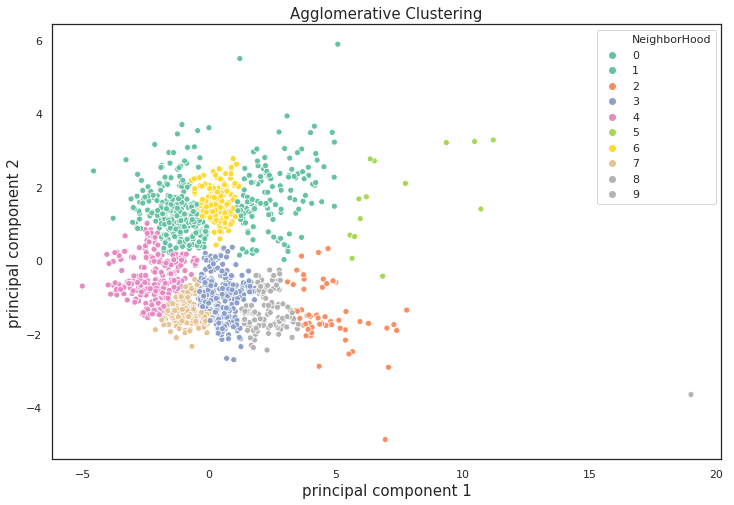

In [0]:
fig = plt.figure(figsize = (12,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Agglomerative Clustering', fontsize = 15)
plt.legend(bbox_to_anchor=(1, 1), loc=2)

sns.scatterplot(x='principal component 1',y='principal component 2',hue='NeighborHood',data=finalDf,legend="full",palette='Set2')

**15 Clusters**

It becomes difficult to differentiate the boundaries when analyzed with
15 clustered neighborhood.

In [0]:
clustering = AgglomerativeClustering(n_clusters=15,
                                    linkage="ward", affinity="euclidean").fit(principalDf)
finalDf = pd.concat([principalDf, pd.DataFrame(data={'NeighborHood':clustering.labels_})], axis = 1)
finalDf.shape

finalDf.columns

Index(['principal component 1', 'principal component 2', 'NeighborHood'], dtype='object')

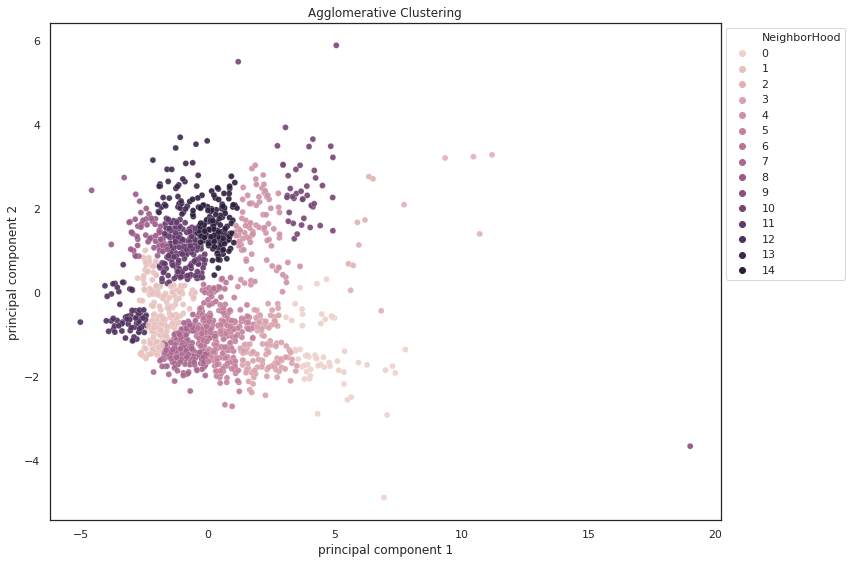

In [0]:
fig = plt.figure(figsize = (12,8))

sns.scatterplot(x="principal component 1", y="principal component 2", hue="NeighborHood", data=finalDf, 
                legend="full", linewidth=0.2, alpha=0.9)
plt.title(f"Agglomerative Clustering")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.tight_layout()
plt.show()

**FCluster and TSNE**

After using TSNE, the neighborhood boundaries were more distinguishable as compared to applying PCA.

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer,MinMaxScaler, RobustScaler

nrm = Normalizer()
nrm.fit(temp)
normal_data = nrm.transform(temp)

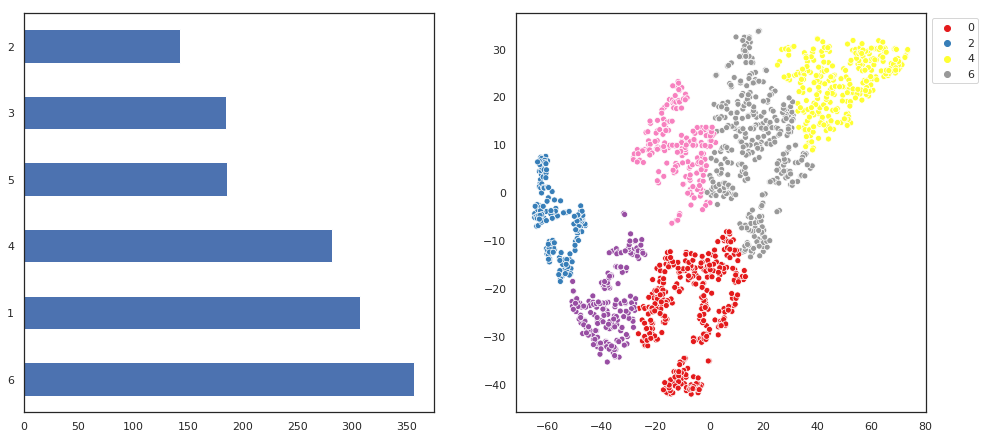

In [0]:
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import ward, fcluster

tsn = TSNE(random_state=20)
res_tsne = tsn.fit_transform(normal_data)

link = ward(res_tsne)
vb = fcluster(link,t=300, criterion='distance')
fig = plt.figure(figsize=(25,25))
ax1 = fig.add_subplot(3,3,1)
pd.value_counts(vb).plot(kind='barh')
ax2 = fig.add_subplot(3,3,2)
axpl_2 = sns.scatterplot(x=res_tsne[:,0],y=res_tsne[:,1],hue=vb,palette="Set1");
axpl_2.legend(bbox_to_anchor=(1, 1), loc=2)

Above graphs, shows that the number of houses with more similar features are clustered in 6.

**Dendrogram for Clusters**

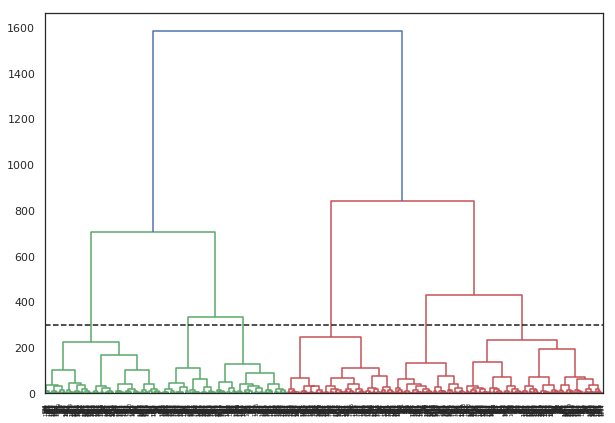

In [0]:
sns.set(style='white')
plt.figure(figsize=(10,7))
#link = ward(res_tsne)
dendrogram(link)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [300,300],'--', c='k')
ax.plot(bounds,'--', c='k')
plt.show()

The clades are arranged according to similar (or dissimilar) they are in the above dendrogram. Clades that are close to the same height are similar to each other; clades with different heights are dissimilar — the greater the difference in height, the more dissimilarity (you can measure similarity in many different ways;

**Silhouette Plot**

Text(0.5, 0, 'Silhouette coefficient')

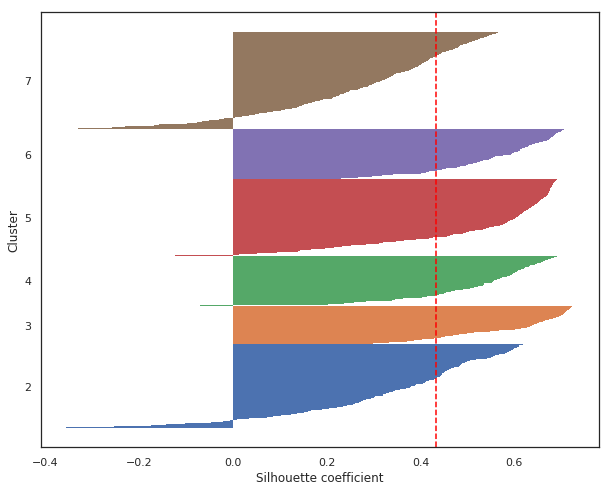

In [0]:
from sklearn.metrics import silhouette_samples, silhouette_score

assign = vb
cluster_labels=np.unique(assign)
n_clusters = len(np.unique(assign))
n_clusters
silhouette_vals = silhouette_samples(res_tsne, assign, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
plt.figure(figsize=(10,8))
for i , c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[assign==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        plt.barh(range(y_ax_lower,y_ax_upper),
                c_silhouette_vals,height=1.0,edgecolor='none')
        yticks.append((y_ax_lower+y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg,color="red",linestyle= "--")
plt.yticks(yticks , cluster_labels + 1)
plt.ylabel ('Cluster')
plt.xlabel('Silhouette coefficient')

Applied two clustering:

**Agglomerative Clustering** - Used PCA for reducing the features to 2 and then applied Agglomerative Clustering. It turned out that choice of 5 clusters worked well as we were able to distinguish the neighborhood boundaries.

**FCluster** - It seems that the choice of 6 clusters is optimal. Used TSNE for dimension reduction. Silhouette coeffiecient for the cluster is 0.5.



## Part 6 - Linear Regression

**Converting Categorical data to numerical format.**

Used two methods for it:

1. Label Encoding - It performed better for the model. Hence, used this. Assumed NAN as a category type by replacing nan with a string and then performed Label Encoding.

2. Used factorize of pandas earlier but it did not perform well with the model.

In [0]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

temp_train = train_data
temp_test = test_data

for f in temp_train.columns:
  if f not in cols_to_drop and f!='SalePrice':
    if temp_train[f].dtype=='object' or temp_test[f].dtype=='object': 
      print("label encoding ",f)
      temp_train[f].fillna("NaN", inplace = True)
      temp_test[f].fillna("NaN", inplace = True)
      lbl = preprocessing.LabelEncoder()
      lbl.fit(list(temp_train[f].values) + list(temp_test[f].values))
      temp_train[f] = lbl.transform(list(temp_train[f].values))
      temp_test[f] = lbl.transform(list(temp_test[f].values))

train_data = temp_train
test_data = temp_test
print(train_data.shape)
print(test_data.shape)



label encoding  MSZoning
label encoding  Street
label encoding  LotShape
label encoding  LandContour
label encoding  LotConfig
label encoding  LandSlope
label encoding  Neighborhood
label encoding  Condition1
label encoding  Condition2
label encoding  BldgType
label encoding  HouseStyle
label encoding  RoofStyle
label encoding  RoofMatl
label encoding  Exterior1st
label encoding  Exterior2nd
label encoding  MasVnrType
label encoding  ExterQual
label encoding  ExterCond
label encoding  Foundation
label encoding  BsmtQual
label encoding  BsmtCond
label encoding  BsmtExposure
label encoding  BsmtFinType1
label encoding  BsmtFinType2
label encoding  Heating
label encoding  HeatingQC
label encoding  CentralAir
label encoding  Electrical
label encoding  KitchenQual
label encoding  Functional
label encoding  FireplaceQu
label encoding  GarageType
label encoding  GarageFinish
label encoding  GarageQual
label encoding  GarageCond
label encoding  PavedDrive
label encoding  Fence
label encoding  

In [0]:
train_data.isnull().sum()[train_data.isnull().sum() > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

**IMPUTING NANs**

1. Checked if some column contains some infinite value, then replaced with NaN

2. Imputed NANs with the median of the column as the mean might not be a good way to impute if the columns are affected by outliers.


In [0]:
for i in train_data.columns:
    train_data[i].fillna(train_data[i].median(),inplace=True) # filled with median because mean may be affected by outliers.

print(train_data.isnull().sum()[train_data.isnull().sum() > 0])

for i in test_data.columns:
    test_data[i].fillna(test_data[i].median(),inplace=True)
print(test_data.isnull().sum()[test_data.isnull().sum() > 0])

Series([], dtype: int64)
Series([], dtype: int64)


In [0]:
#interpolate missing values 
dt = train_data.select_dtypes(include=[np.number]).interpolate().dropna()

#check if all cols have zero null values 
print(sum(dt.isnull().sum()!=0))

0


**Linear Regression without regularization**

Selected the most correlated features as found in part 1 . Also, added some negativley correlated feature. Model performed well with 11 features giving score of 0.81 and RMSE 0.031944414428116234.



In [0]:
train_data['SalePrice_Log'] = np.log(train_data['SalePrice'])
X_train = train_data[["MSSubClass","LotArea","LotFrontage","OverallQual","OverallCond","YearBuilt","YearRemodAdd","MasVnrArea","BsmtFinSF1", 
                 "1stFlrSF","GarageCars"]]
y_train = train_data[["SalePrice_Log"]]

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.33,random_state= 42)

In [0]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.8125672994797011

In [0]:
preds = reg.predict(X_test)
print ('RMSE: ', mean_squared_error(y_test, preds))

RMSE:  0.031944414428116234


**Top Features**

In [0]:
cols = ["MSSubClass","LotArea","LotFrontage","OverallQual","OverallCond","YearBuilt","YearRemodAdd","MasVnrArea","BsmtFinSF1", 
                 "1stFlrSF","GarageCars"]
coeff = reg.coef_[0].tolist()

coeff_list =[]
for i in range(len(cols)):
  coeff_list.append((cols[i], coeff[i]))
coeff_list.sort(key=lambda x:x[1], reverse=True)
coeff_list

[('OverallQual', 0.13316150130795884),
 ('GarageCars', 0.12435664548032431),
 ('OverallCond', 0.035312014920169874),
 ('YearRemodAdd', 0.0018766280103070599),
 ('YearBuilt', 0.001441991268069582),
 ('1stFlrSF', 0.00013374363001026574),
 ('BsmtFinSF1', 6.089562651734619e-05),
 ('MasVnrArea', 5.547183277359019e-05),
 ('LotArea', 3.7049137157284066e-06),
 ('LotFrontage', -7.018479869521819e-07),
 ('MSSubClass', -0.00039540456583208634)]

In [0]:
X_test = test_data[["MSSubClass","LotArea","LotFrontage","OverallQual","OverallCond","YearBuilt","YearRemodAdd","MasVnrArea","BsmtFinSF1", "1stFlrSF","GarageCars"]]
predicted_prices = reg.predict(X_test)
predicted_prices_list = []
for predict in predicted_prices:
    predicted_prices_list.append(np.exp(predict[0]))



In [0]:
submission = pd.DataFrame({"Id": test_data.Id, 'SalePrice': predicted_prices_list})
submission.to_csv('submission_simple_linear_reg.csv', index=False)

## Part 7 - External Dataset

Took Crime rate data from https://www.macrotrends.net/cities/us/ia/ames/crime-rate-statistics 

In [258]:
# TODO: code to import external dataset and test
external_data = pd.read_csv("ia-population-2019-10-19.csv")
external_data.columns

Index(['YrSold', 'Ames', 'IA', 'US'], dtype='object')

In [259]:
ext_merged = train_data.merge(external_data, on='YrSold', how='left')
ext_merged.head()

Id  MSSubClass  MSZoning  ...       Ames         IA         US
0   1          60         4  ...  2961.1396  2440.3550  3214.5500
1   2          20         4  ...  3103.3280  2648.3193  3276.3657
2   3          60         4  ...  2961.1396  2440.3550  3214.5500
3   4          70         4  ...  2788.2987  2823.5949  3346.5771
4   5          60         4  ...  2961.1396  2440.3550  3214.5500

[5 rows x 81 columns]

**Merging the original dataset with the external dataset**

In [0]:
ext_merged['SalePrice_Log'] = np.log(ext_merged['SalePrice'])
X_train = ext_merged[["MSSubClass","LotArea","LotFrontage","OverallQual","OverallCond","YearBuilt","YearRemodAdd","MasVnrArea","BsmtFinSF1", 
                 "1stFlrSF","GarageCars","Ames"]]
y_train = ext_merged[["SalePrice_Log"]]

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.3,random_state= 0)

In [262]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.7545228391685201

In [263]:
preds = reg.predict(X_test)
print ('RMSE: ', mean_squared_error(y_test, preds))

RMSE:  0.03792895470859967


Model did not perform well with the crime data. The score reduced to 0.75 from 0.82 and RMSE increased from 0.031 ro 0.037 


## Part 8 - Permutation Test

**Function for training single features**

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import permutation_test


def train_single_feature(col_name):
  X_train = train_data[[col_name]]
  y_train = train_data[["SalePrice_Log"]]
  X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.5,random_state=0)
  reg = LinearRegression().fit(X_train, y_train)
  print("***********" + col_name+"**************")
  print('R-Square : ',reg.score(X_test, y_test))
  
  preds = reg.predict(X_test)
  print('RMSE: ', mean_squared_error(y_test, preds))
  
  predicted_prices_list = []
  for predict in preds:
      predicted_prices_list.append(predict[0])
  temp_target = predicted_prices_list
  temp_ref = y_test["SalePrice_Log"].values.tolist()
  
  return temp_target, temp_ref 

**Monte Carlo Permutation Test**

Created function for Permutation test using Monte Carlo Algorithm

In [0]:
def perm_test(ref, target, perms):
    n, k = len(ref), 0
    diff = np.abs(np.mean(ref) - np.mean(target))
    combined = np.concatenate([ref, target])
    for j in range(perms):
        np.random.shuffle(combined)
        k += diff <= np.abs(np.mean(combined[:n]) - np.mean(combined[n:]))
    return k / perms

**LotArea vs SalePrice_log**

In [266]:
temp_target, temp_ref = train_single_feature("LotArea")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********LotArea**************
R-Square :  0.07484229780195052
RMSE:  0.14494637525218945
p-value :  0.96
p-value using monte carlo :  0.92


**OverallQual vs SalePrice_Log**

In [267]:
temp_target, temp_ref = train_single_feature("OverallQual")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********OverallQual**************
R-Square :  0.6671477909176243
RMSE:  0.052148645670407265
p-value :  0.52
p-value using monte carlo :  0.48


**OverallCond vs SalePrice_Log**

In [268]:
temp_target, temp_ref = train_single_feature("OverallCond")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********OverallCond**************
R-Square :  0.0003901457713859635
RMSE:  0.15661094826597505
p-value :  0.82
p-value using monte carlo :  0.83


**YearBuilt vs SalePrice_Log**

In [269]:
temp_target, temp_ref = train_single_feature("YearBuilt")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********YearBuilt**************
R-Square :  0.360291264513232
RMSE:  0.10022449384107193
p-value :  0.86
p-value using monte carlo :  0.9


**MasVnrArea vs SalePrice_Log**

In [270]:
temp_target, temp_ref = train_single_feature("MasVnrArea")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********MasVnrArea**************
R-Square :  0.16937670988679732
RMSE:  0.13013547292090016
p-value :  0.35
p-value using monte carlo :  0.28


**GarageCars vs SalePrice_Log**

In [271]:
temp_target, temp_ref = train_single_feature("GarageCars")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********GarageCars**************
R-Square :  0.4330769163003735
RMSE:  0.0888210148754331
p-value :  0.31
p-value using monte carlo :  0.29


**KitchenAbvGr vs SalePrice_Log**

In [272]:
temp_target, temp_ref = train_single_feature("KitchenAbvGr")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********KitchenAbvGr**************
R-Square :  0.021423560686580467
RMSE:  0.1533155995444658
p-value :  0.97
p-value using monte carlo :  0.97


**MSSubClass vs SalePrice_Log**

In [273]:
temp_target, temp_ref = train_single_feature("MSSubClass")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********MSSubClass**************
R-Square :  0.007026256832487698
RMSE:  0.15557125498796165
p-value :  0.8
p-value using monte carlo :  0.79


**1stFlrSF vs SalePrice_Log**

In [274]:
temp_target, temp_ref = train_single_feature("1stFlrSF")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********1stFlrSF**************
R-Square :  0.3341553979179774
RMSE:  0.10431925424576453
p-value :  0.86
p-value using monte carlo :  0.92


**TotalBsmtSF vs SalePrice_Log**

In [275]:
temp_target, temp_ref = train_single_feature("TotalBsmtSF")
p_value = permutation_test(temp_ref, temp_target,
                           method='approximate',
                           num_rounds=100,
                           seed=0)

monte_carlo_p_value = perm_test(temp_ref, temp_target, 100)

print("p-value : ",p_value)

print("p-value using monte carlo : ", monte_carlo_p_value)

***********TotalBsmtSF**************
R-Square :  0.31493500885910886
RMSE:  0.1073305524475747
p-value :  0.9
p-value using monte carlo :  0.92


Most Significant featrures are **TotalBsmtSF, KitchenAbvGr**,and **LotArea** are significant features as their p value is high.

## Best Prediction Model

**XGB Regressor**

Model performed better than Linear regression. Used GridSearchCV for finding best parameters for XGBoost Model

In [0]:
y = np.log(train_data.SalePrice)
X = dt.drop(['Id','SalePrice'], axis=1)

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33,random_state= 42)

In [278]:
import warnings
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

warnings.filterwarnings("ignore")

gbm = xgb.XGBRegressor()
reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=1)
reg_cv.fit(X_train,y_train)
reg_cv.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[18:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   48.2s finished


[18:37:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 1.0,
 'max_depth': 3,
 'min_child_weight': 1.2,
 'n_estimators': 500}

In [279]:
gbm = xgb.XGBRegressor(**reg_cv.best_params_)
gbm.fit(X_train,y_train)

submit= pd.DataFrame()
submit['Id'] = test_data.Id
test_features = test_data.select_dtypes(include=[np.number]).drop(['Id'], axis=1).interpolate()
preds = gbm.predict(test_features)
final_preds = np.exp(preds)

[18:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [280]:
print("R-Square : " ,gbm.score(X_test,y_test))

R-Square :  0.8911104259952205


In [0]:
submit['SalePrice'] = final_preds
submit.to_csv('xgb_hyper_param_subm.csv', index=False)

**Linear Regression**

In [282]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
from sklearn.metrics import mean_squared_error

model = lr.fit(X_train, y_train)

print("R-Square : " ,model.score(X_test,y_test))

preds = model.predict(X_test)
print ('RMSE: ', mean_squared_error(y_test, preds))

R-Square :  0.8635146635956683
RMSE:  0.023261384685585598


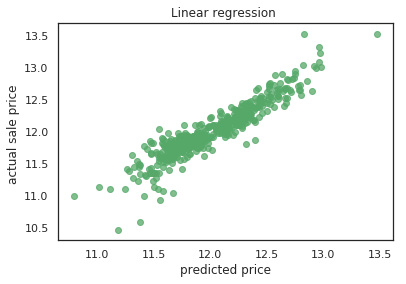

In [283]:
plt.scatter(preds, y_test, alpha=.75, color='g')
plt.xlabel('predicted price')
plt.ylabel('actual sale price ')
plt.title('Linear regression ')
plt.show()

**Ridge Regression with Regularization**

In [0]:
alpha = 0.01

rm = linear_model.Ridge(alpha=alpha)
ridge_model = rm.fit(X_train, y_train)
preds_ridge = ridge_model.predict(X_test)

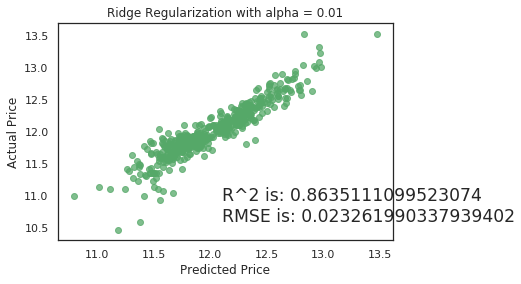

In [285]:
plt.scatter(preds_ridge, y_test, alpha=.75, color='g')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ridge Regularization with alpha = {}'.format(alpha))
overlay = 'R^2 is: {}\nRMSE is: {}'.format(ridge_model.score(X_test, y_test),
                                           mean_squared_error(y_test, preds_ridge))
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

**Random Forest Regressor**

In [286]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


forest = RandomForestRegressor(n_estimators = 100,random_state=1,n_jobs=1)
forest.fit(X_train,y_train)

parameters = [{'n_estimators':[10,100],
               'min_samples_split':[2,4],
               'min_samples_leaf':[1,2]}]
    
grid_search = GridSearchCV(estimator = forest,
                           param_grid = parameters,
                           cv = 5,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train,y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

forest = RandomForestRegressor(n_estimators = 100,
                               min_samples_leaf = 1,
                               min_samples_split = 4,
                               random_state = 1,
                               n_jobs = 1)

forest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                      oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [287]:
print("R-Square : " ,forest.score(X_test,y_test))

preds = forest.predict(X_test)
print ('RMSE: ', mean_squared_error(y_test, preds))

R-Square :  0.8725407943794786
RMSE:  0.021723048730119883


**Gradient Boost Regressor**

This model gave me best score after reducing the learning rate. Increasing no of splits did not give any impact on the performance of the model.

In [0]:
from sklearn.ensemble  import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.005,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)
gbr.fit(X_train,y_train)

submit= pd.DataFrame()
submit['Id'] = test_data.Id
test_features = test_data.select_dtypes(include=[np.number]).drop(['Id'], axis=1).interpolate()
preds = gbr.predict(test_features)
final_preds = np.exp(preds)

In [289]:
print("R-Square : ",gbr.score(X_test,y_test))

R-Square :  0.9079745144978492


In [0]:
submit['SalePrice'] = final_preds
submit.to_csv('gradient_boost_hyper_param_subm.csv', index=False)

**LightGBM Regressor**

In [0]:
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(objective='regression', 
                         num_leaves=6,
                         learning_rate=0.005, 
                         n_estimators=8000,
                         max_bin=200, 
                         bagging_fraction=0.8,
                         bagging_freq=4, 
                         bagging_seed=8,
                         feature_fraction=0.2,
                         feature_fraction_seed=8,
                         min_sum_hessian_in_leaf = 11,
                         verbose=-1,
                         random_state=42)

lightgbm.fit(X_train,y_train)

submit= pd.DataFrame()
submit['Id'] = test_data.Id
test_features = test_data.select_dtypes(include=[np.number]).drop(['Id'], axis=1).interpolate()
preds = lightgbm.predict(test_features)
final_preds = np.exp(preds)

In [292]:
print("R-Square : " ,lightgbm.score(X_test,y_test))

R-Square :  0.8999573652530098


In [0]:
submit['SalePrice'] = final_preds
submit.to_csv('lightgbm_hyper_param_subm.csv', index=False)

**Comparison of Models**

In [294]:
import time
from sklearn import model_selection

start = time.time() # Get start time
models = []
models.append(('Linear Regression', lr))
models.append(('Ridge Regression', rm))
models.append(('Random Forest', forest))
models.append(('XGBoost Regressor', gbm))
models.append(('Gradient Boosting Regressor', gbr))
models.append(('LGBM Regressor',lightgbm))


# set table to table to populate with performance results
rmse_results = []
names = []
col = ['Algorithm', 'RMSE Mean', 'RMSE SD']
df_results = pd.DataFrame(columns=col)

# evaluate each model using cross-validation
kfold = model_selection.KFold(n_splits=5, shuffle = True, random_state=7)
i = 0
for name, model in models:
    print("Evaluating {}...".format(name))
    
    # -mse scoring
    cv_mse_results = model_selection.cross_val_score(
        model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    
    
    # calculate and append rmse results
    cv_rmse_results = np.sqrt(-cv_mse_results)
    rmse_results.append(cv_rmse_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_rmse_results.mean(), 4),
                         round(cv_rmse_results.std(), 4)]
    i += 1
end = time.time() # Get end time
eval_time = (end-start)/60 # Calculate training time
print('Evaluation completed.\nIt took {0:.2f} minutes to evaluate all models using a 5-fold cross-validation.'.format(eval_time))
df_results.sort_values(by=['RMSE Mean'], ascending=True).reset_index(drop=True)

Evaluating Linear Regression...
Evaluating Ridge Regression...
Evaluating Random Forest...
Evaluating XGBoost Regressor...
[18:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Evaluating Gradient Boosting Regressor...
Evaluating LGBM Regressor...
Evaluation completed.
It took 1.41 minutes to evaluate all models using a 5-fold cross-validation.


Algorithm  RMSE Mean  RMSE SD
0               LGBM Regressor     0.1237   0.0070
1  Gradient Boosting Regressor     0.1248   0.0110
2            XGBoost Regressor     0.1257   0.0067
3                Random Forest     0.1465   0.0071
4            Linear Regression     0.1561   0.0274
5             Ridge Regression     0.1561   0.0274

The best performed models are Gradient Boost and LightGbm Regressors.

Both performed equally well with slight difference in RMSE, but Gradient boost regressor gave the best score in Kaggle. 

## Part 9 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/anujverma19

Highest Rank: **1688**

Score: **0.12796**

Number of entries: **11**

**KAGGLE RANKING**

In [298]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

Saving Screenshot (119).png to Screenshot (119).png


**Scores**

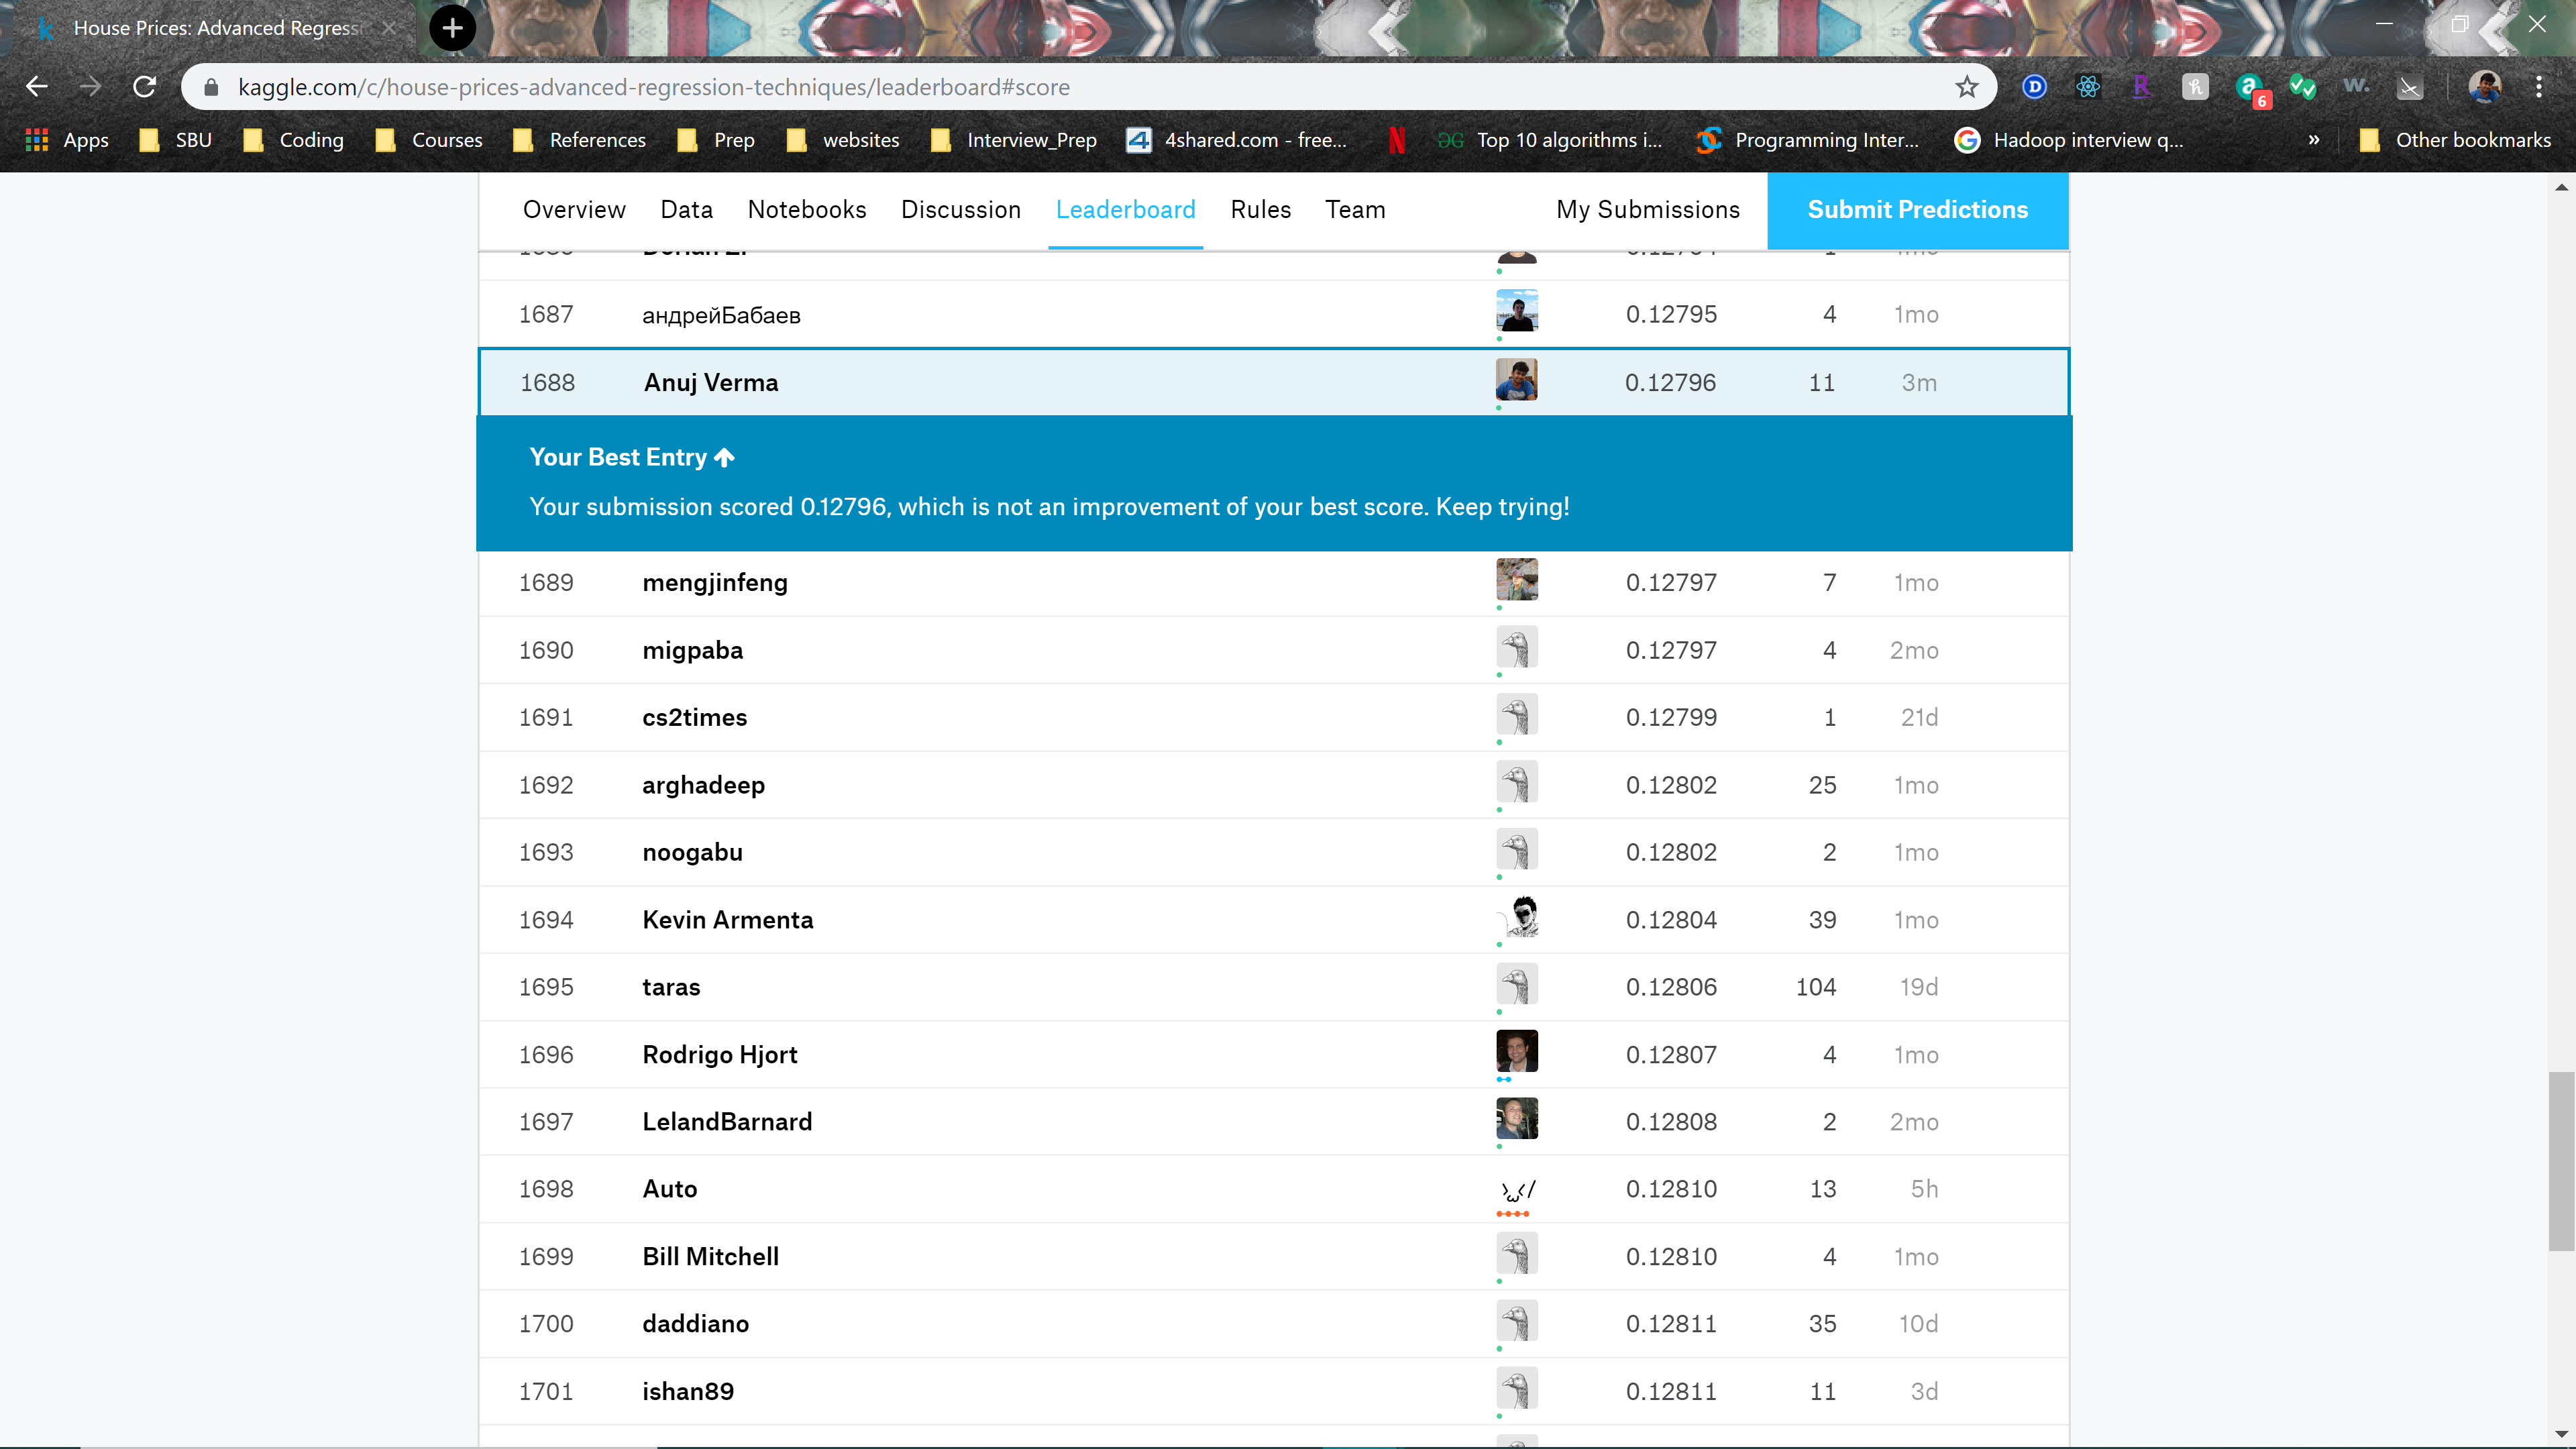

In [297]:
Image('Ranking.png', width=1000)

**Ranking**

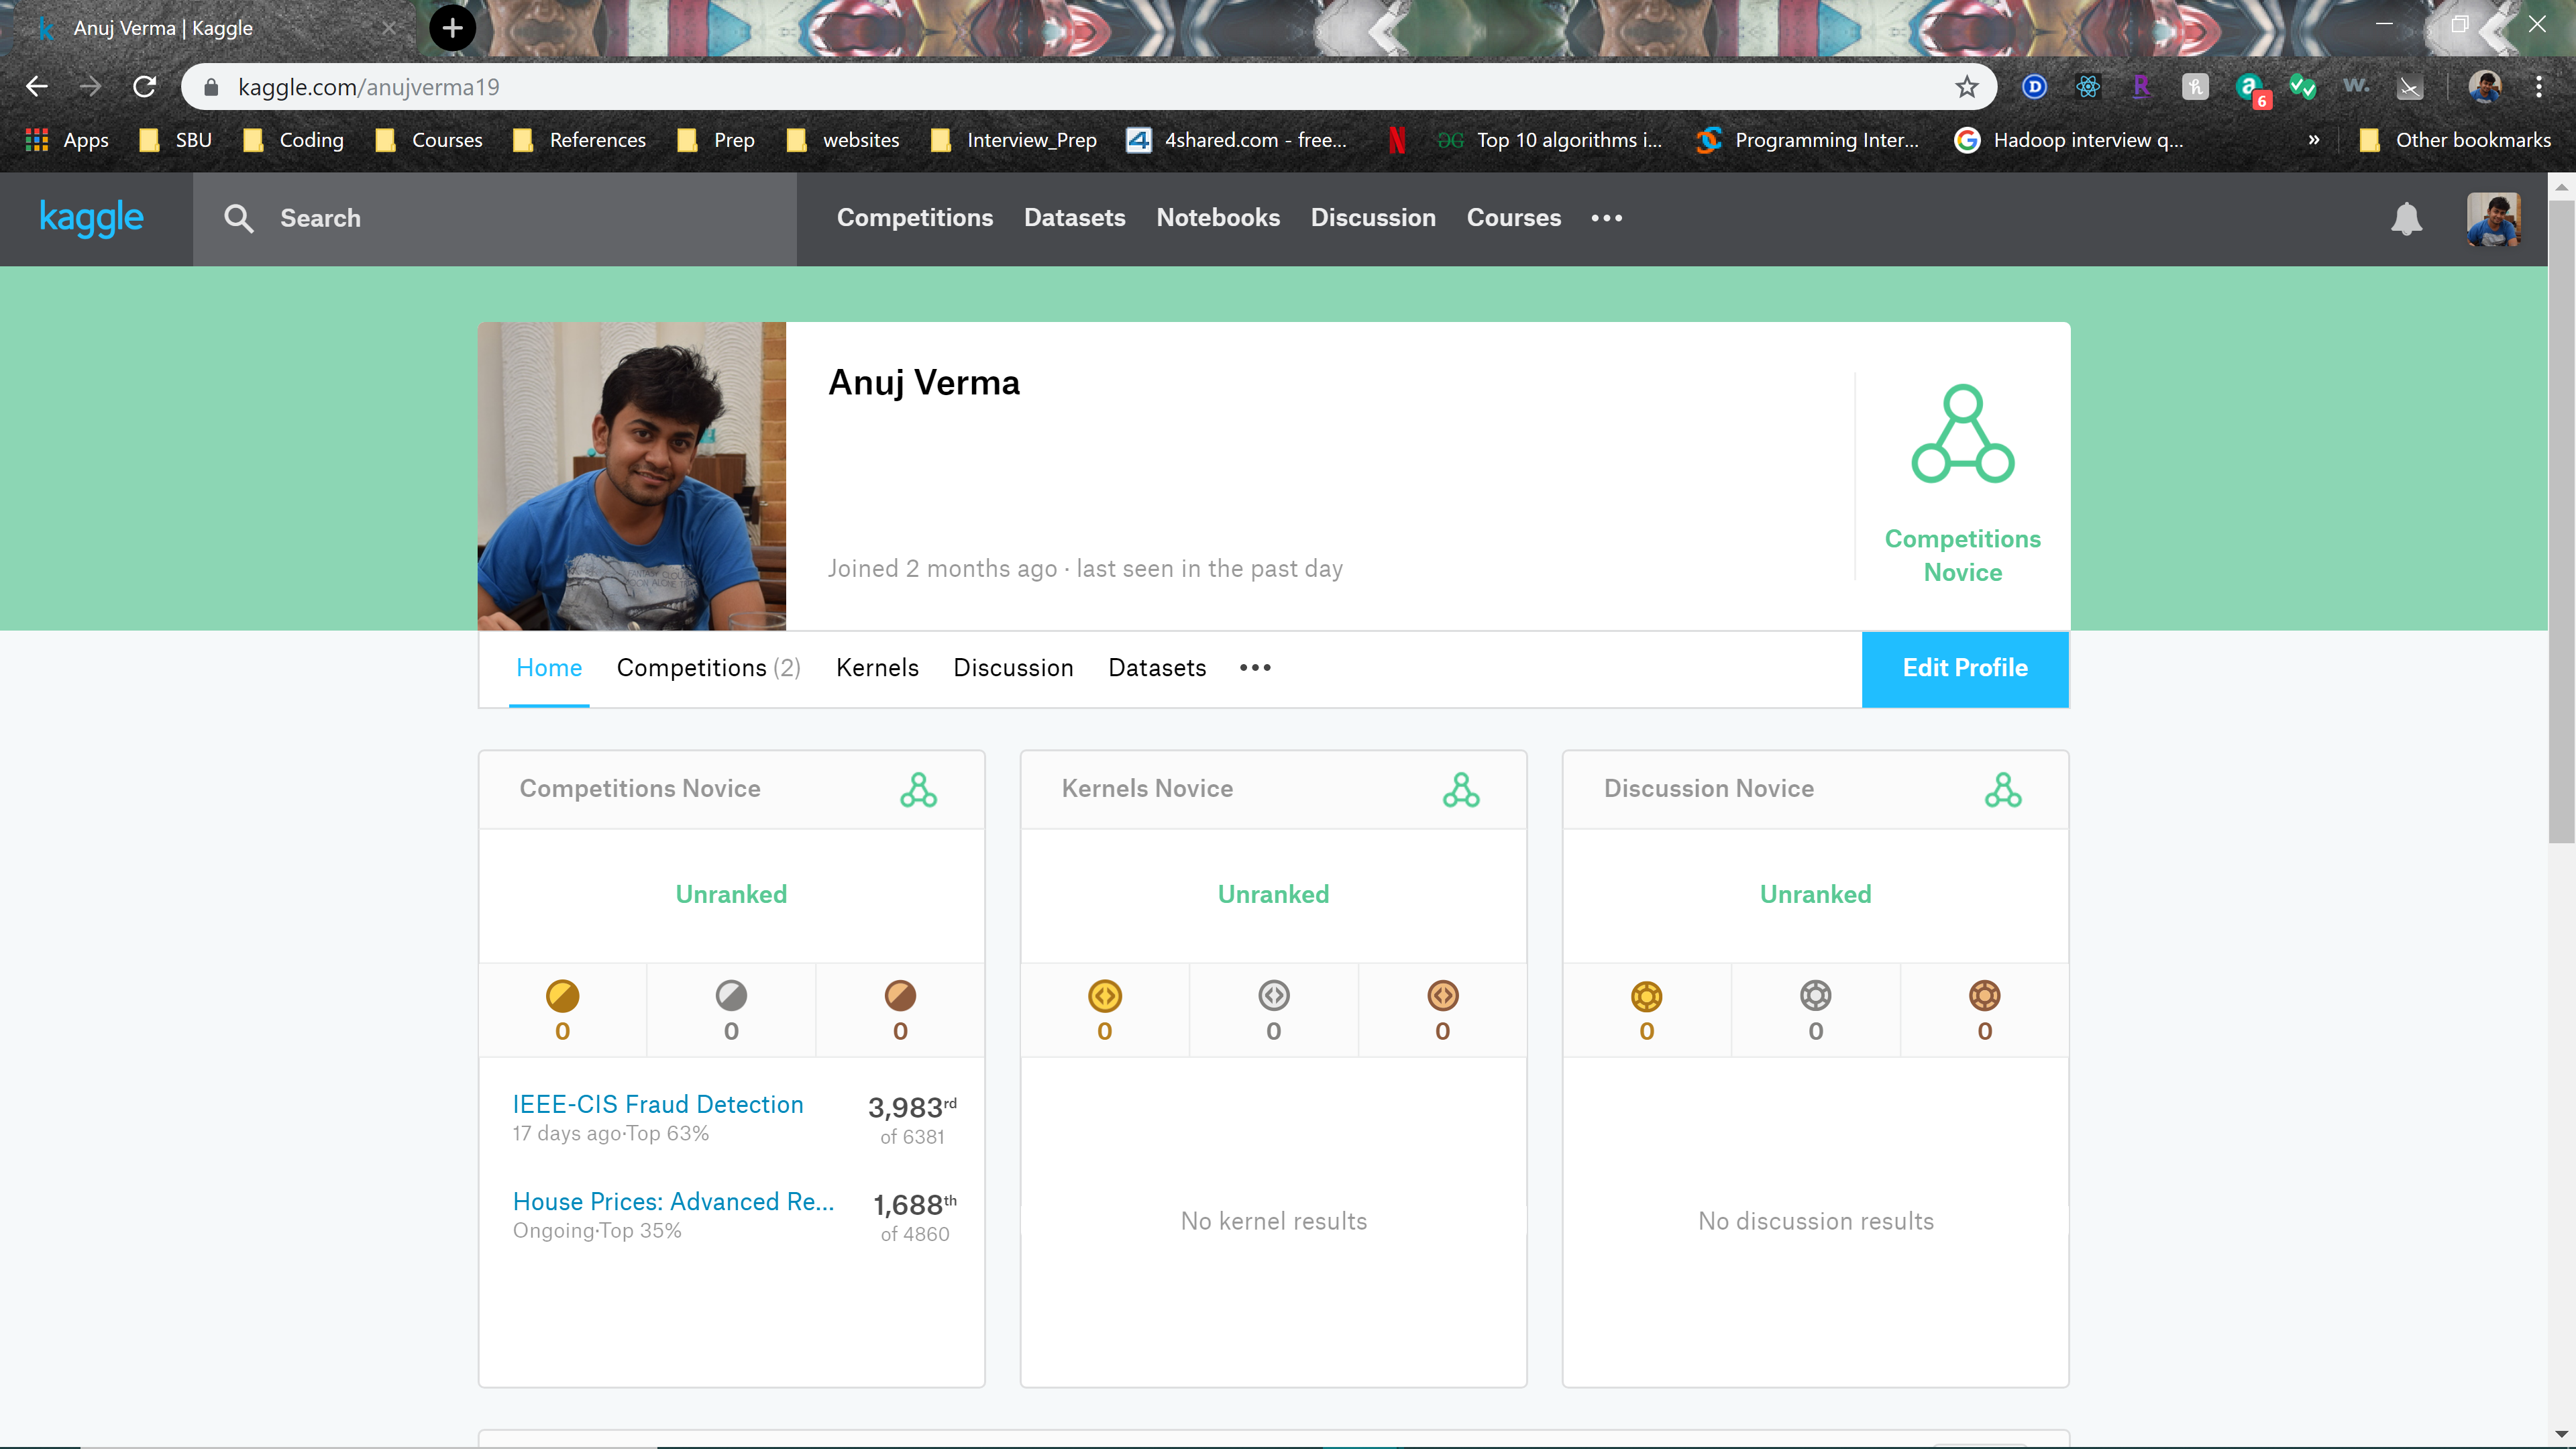

In [299]:
Image('Screenshot (119).png', width=1000)